In [13]:
#
# https://github.com/elbazam/multi_object_tracking
##
import numpy as np
import cv2
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from enum import Enum



# 
# load C4dynamics
## 
exec(open('importc4d.py').read())

In [14]:
#
# user input
##
videoname = 'cars1'
videoin  = os.path.join(os.getcwd(), 'examples', videoname + '.mp4')
videoout = os.path.join('out', videoname + '.mp4')

In [15]:
# 
# cvideo preprocessing 
#
# initializes video-related parameters such as the frame rate (dt), 
# and retrieves the first frame to determine the video's width and height.
##

def openvideo():
    cvideo       = cv2.VideoCapture(videoin)
    dt          = 1 / cvideo.get(cv2.CAP_PROP_FPS)
    Nframes     = int(cvideo.get(cv2.CAP_PROP_FRAME_COUNT))
    tf_video    = Nframes * dt 

    fwidth  = int(cvideo.get(cv2.CAP_PROP_FRAME_WIDTH))
    fheight = int(cvideo.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_out  = cv2.VideoWriter(videoout, cv2.VideoWriter_fourcc(*'mp4v')
                    , int(cvideo.get(cv2.CAP_PROP_FPS)), [fwidth, fheight])

    return cvideo, video_out, tf_video, fwidth, fheight, dt

cvideo, video_out, tf_video, fwidth, fheight, dt = openvideo()



In [16]:
# initializes the object detector (Yolo Detector). 
# passing the video's height and width.
yolodet = c4d.detectors.yolo(height = fheight, width = fwidth)

In [17]:
# plt.imshow(mpimg.imread(os.path.join(os.getcwd(), 'out', 'before.png')))
# plt.axis('off')
# plt.show()

In [18]:
# x(t) = A(t) * x(t-1) + e(t) || e(t) ~ N(0,Q(t))
# z(t) = H(t) * x(t) + r(t)   || r(t) ~ N(0,R(t))

# x(t) = [x1 y1 x2 y2 vx vy]

A = np.array([[1, 0, 0, 0, dt, 0 ]
            , [0, 1, 0, 0, 0,  dt]
            , [0, 0, 1, 0, dt, 0 ]
            , [0, 0, 0, 1, 0,  dt]
            , [0, 0, 0, 0, 1,  0 ]
            , [0, 0, 0, 0, 0,  1 ]])

H = np.array([[1, 0, 0, 0, 0, 0]
            , [0, 1, 0, 0, 0, 0]
            , [0, 0, 1, 0, 0, 0]
            , [0, 0, 0, 1, 0, 0]])

P = np.eye(A.shape[1])

Q = np.array([[25, 0,  0,  0,  0,  0]
            , [0,  25, 0,  0,  0,  0]
            , [0,  0,  25, 0,  0,  0]
            , [0,  0,  0,  25, 0,  0]
            , [0,  0,  0,  0,  49, 0]
            , [0,  0,  0,  0,  0,  49]])

R = dt * np.eye(4)


In [19]:
class trkstate(Enum):
    CLOSED      = 0
    PREDICTED   = 1
    CORRECTED   = 2


    
class tracker(c4d.datapoint):
    # a datapoint 
    # kalman filter 
    # display color
    ## 
    
    def __init__(obj, z):

        super().__init__()  # Call the constructor of c4d.datapoint
         
        obj.filter = c4d.filters.kalman(np.hstack((z, np.zeros(2))), P, A, H, Q, R)
        
        obj.counterSame = 0
        obj.counterEscaped = 0
        obj.appear = 0
        obj.state = trkstate.PREDICTED

        obj.color = [np.random.randint(0, 255)
                        , np.random.randint(0, 255)
                            , np.random.randint(0, 255)]



    def isvalid(obj, measure):
        # 
        # abosultely unclear.
        # if already should have been inverse. 
        # when above some threshold then show.  
        ## 
        if len(measure) == 0:
            return False
        elif obj.appear < 8:
            return True
        
        #
        # otherwise, innovation test
        ## 
        innovation = measure - np.dot(obj.filter.H, obj.filter.x)
        S = np.dot(obj.filter.H, np.dot(obj.filter.P, obj.filter.H.T)) + obj.filter.R
        epsilon = np.dot(innovation.T, np.dot(np.linalg.inv(S), innovation))
        return epsilon < 9.488 # chi

        


    
    def nextposition(obj):
        # kalman states:
        #   x(t) = [x1 y1 x2 y2 vx vy]
        # then x[:4] are the center coords.
        ##
        return np.array(obj.filter.x[:4].astype(np.int32))


    def getvelocity(obj):
        # kalman states:
        #   x(t) = [x1 y1 x2 y2 vx vy]
        # then x[4:] are the velocity coords.
        ## 
        return obj.filter.x[4:].astype(np.int32)


    def getcenter(obj):
        center = np.zeros(2)
        state = obj.nextposition()
        center[0] = 0.5 * (state[0] + state[2])
        center[1] = 0.5 * (state[1] + state[3])
        return center.astype(np.int32)



    def duplicated(obj):
        obj.counterSame += 1
        if obj.counterSame > 3:
            return True
        return False
    


    def advance(obj, corrected):

        if corrected:
            obj.counterEscaped = 0
            obj.appear += 1
            obj.state = trkstate.CORRECTED
        else:
            obj.counterEscaped += 1

            if obj.counterEscaped > 40:
                obj.state = trkstate.CLOSED
            else:
                obj.state = trkstate.PREDICTED

            
    
    
    def __eq__(obj, other):
        x1 = obj.nextposition()
        x2 = other.nextposition()
        if np.linalg.norm(x1 - x2) < 10: 
            return True 

In [26]:
# trackers manager:
#   list of active trackers
#   add or remove tracks methods
class mTracks:
    #
    # this class shouldnt belong to this project notebook but to the body module of c4d.
    # theres also should be a saperation between the objects detecton processing and the objects bank handling. 
    # however this class cannot currently be introduced as is to c4dyanmics as it doesnt handle body objects but handles tracks
    # which is another class of this nb. 
    ## 
    
    def __init__(obj):
        obj.trackers = {}
        # obj.removelist = []
        obj.neigh = NearestNeighbors(n_neighbors = 1)
        # threshold of 100 pixels to verify the measure is close enough to the object. 
        obj.thresh = 100 


    def add(obj, key, z):
        obj.trackers[key] = tracker(z)
    

    def trackerMaker(obj, zList, cov):
        # updates the existing trackers based on a list of
        # new observations zList. 
        # uses the Nearest Neighbors algorithm to 
        # find the nearest observation for each tracker, associates them, and 
        # then creates new trackers for any unassociated observations.
        
        RestOfZ = np.copy(zList)
        check = NearestNeighbors(n_neighbors = 1)
        check.fit(zList)
        AssociatedZ = []
        delist = []
        
        for kf in obj.trackers.values():
            
            kfPose = [kf.nextposition()]
            _, idx = check.kneighbors(kfPose)
            
            if idx[0][0] not in delist:
                AssociatedZ.append(zList[idx[0][0]])
                delist.append(idx[0][0])
                
                
        AssociatedZ = np.array(AssociatedZ)
        RestOfZ = np.delete(RestOfZ, delist, 0)
        
        if list(obj.trackers.keys()):
            lastKey = list(obj.trackers.keys())[-1] + 1
            while lastKey in list(obj.trackers.keys()):
                lastKey += 1
        else:
            lastKey = 0
            
        RestOfZSize = AssociatedZ.shape[0]
        
        if RestOfZSize > 0 and not lastKey == 0:
            check.fit(AssociatedZ)
            
        UpdateTracker = True
        n = zList.shape[1]
        
        
        for z in RestOfZ:
            
            if not lastKey == 0 and RestOfZSize > 0:
                
                UpdateTracker = False
                _, idx = check.kneighbors([z])
                v = z - AssociatedZ[idx[0][0]]
                epsilon = np.dot(v.T, np.dot(np.linalg.inv(cov), v))
                
                if n == 2 and not epsilon < 5.991: 
                    UpdateTracker = True
                elif n == 4 and not epsilon < 9.448: 
                    UpdateTracker = True
            
            if UpdateTracker:
                print(f'opening new track: {lastKey}')
                obj.add(lastKey, z)
                lastKey += 1
                UpdateTracker = False

        
    def refresh(obj, zList, frame, t):
        # updates the state of each tracker:
        #   - Performs measurements handling. \\ isnt the meausre performed in the main? \\ 
        #   - Associates trk id by a nearest neighbor.
        #   - Visualizes the tracked objects on the frame.
        ## 
        for key, kf in obj.trackers.items():
            if kf.state == trkstate.CLOSED:
                continue

            #
            # three options for the trk state in the end of this procedure:
            #   CORRECTED:      if conditions for correct are satisfied
            #   PREDICTED:      if conditions for correct are'nt satisfied
            #   CLOSED:         if counterEscaped exceed threshold 
            ##



            measurement = []

            if zList.shape[0] == 1:
                # if exactly one measure exists, no need to check which is closest 
                # how it knows that it belongs to this track? 
                measurement = zList[0]

            elif zList.shape[0] >= 2:
                # if more than one measure, check which is the closest. 
                # what happens when zlist.shape[0] is not 1 and not bigger than 1? is it at all possible? 
                # if it's impossible then it's better to join the two conditions for correct together, 
                # reset the escape counter and update the measure and do the opposite for false. 
                # 
                # what's the vlaue of doing predict in a phase of correct? 
                ##

                # 
                # d: Distances Array 
                #   This array contains the distances between each sample and its k-nearest neighbors.
                #   Each row corresponds to a sample, and the values in that row represent the distances to its 
                #   k-nearest neighbors.
                # 
                # relativeIndex: Indices Array
                #   This array contains the indices of the k-nearest neighbors for each sample. 
                #   Each row in the array corresponds to a sample in the dataset, and the values 
                #   in that row represent the indices of its k-nearest neighbors in the dataset.
                ##  
                kfPose = np.expand_dims(obj.trackers[key].nextposition(), axis = 0)
                d, relativeIndex = obj.neigh.kneighbors(kfPose)

                if d[0][0] < obj.thresh:
                    # the measure is not too far from the object 

                    z = np.array(zList)[relativeIndex[0]]
                    if len(z) == 1:
                        measurement = z[0]
                    else:
                        npDistances = np.array(d[0])
                        npDistances = npDistances * npDistances
                        weights = 1 - npDistances / np.sum(npDistances)
                        # return np.average(z, weights = weights, axis = 0)
                        measurement = np.average(z, weights = weights, axis = 0)
                    


            corrected = obj.trackers[key].isvalid(measurement)

            if corrected:
                # 
                # correct 
                ##
                obj.trackers[key].filter.correct(measurement)
            else:
                # 
                # predict
                ##
                # obj.trackers[key].filter.predict()
                pass

            #
            # advance trk state, 
            # quit if closed
            ## 
            obj.trackers[key].advance(corrected)            
            if obj.trackers[key].state == trkstate.CLOSED:
                print('closing trk ' + str(key))
                continue


            #
            # prepare to present on the frame
            ##

            pose = obj.trackers[key].nextposition()
            vel = obj.trackers[key].getvelocity() * dt
            center = obj.trackers[key].getcenter()
            color = kf.color
            
            obj.trackers[key].x = center[0]
            obj.trackers[key].y = center[1]
            obj.trackers[key].vx = vel[0]
            obj.trackers[key].vy = vel[1]
            

            obj.trackers[key].store(t)
            obj.trackers[key].storevar('state', t)

            if obj.trackers[key].state == trkstate.CORRECTED: 
                cv2.rectangle(frame, (pose[0], pose[1]), (pose[2], pose[3]), color, 2)
                cv2.putText(frame, 'id: ' + str(key), (center + [0, -10]), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
                cv2.arrowedLine(frame, center, center + vel.astype(np.int32), color, 4)
                
    
    def RemoveDoubles(obj):
        # more trackers than measurements
        # removes duplicate trackers that are close to each other. 
        # compares trackers and removes duplicates based on a threshold.
        ##

        # keys = list(obj.trackers.keys())
        keys = [key for key, value in obj.trackers.items() if not value.state == trkstate.CLOSED]

        KeysVisited = []
        
        for key in keys:
            for inKey in keys:
                if key == inKey or inKey in KeysVisited:
                    continue
                if obj.trackers[key] == obj.trackers[inKey]:

                    

                    if obj.trackers[inKey].duplicated():
                        obj.trackers[inKey].state = trkstate.CLOSED
                        print('closing duplicated trk ' + str(inKey))


            KeysVisited.append(key)
            
        # for inKey in KeysRemove:
        #     print("Removing doubles")
        #     print(f'deleted existing data with key: {inKey}')
        #     try: 
        #         obj.trackers.pop(inKey)
        #     except: 
        #         print('deleted this key before')


In [21]:
def run(tf = tf_video, showmustgoon = True, outfile = None):

    with open(outfile, 'wt') as file:
        file.write(f'')

    mtracks = mTracks()
    
    cov = 25 * np.eye(4)
    t = 0
    
    while cvideo.isOpened():
        
        ret, frame = cvideo.read()
        # frame = frame.astype(np.uint8)
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Assuming input frames are in BGR format
        
        if not ret: 
            break


        
        #
        # the update function runs the main trackers loop.  
        #
        # retrieves object measurements from the current frame using the object detector (YoloDetector).
        ##
        zList = yolodet.getMeasurements(frame, t, outfile) 
        
        if outfile is not None: 
            with open(outfile, 'at') as file:
                file.write(f'zlist: {len(zList)} \n\n')


        # updates the trackers dictionary by adding or removing tracks.  
        # creates new trackers if there are more 
        # measurements than trackers and removes duplicate trackers if 
        # there are more trackers than measurements.
        kfNumber = len(mtracks.trackers.keys())
        zNumber = zList.shape[0]
        
        if kfNumber < zNumber:
            # more measurements than trackers
            mtracks.trackerMaker(zList, cov)
            
        elif kfNumber > zNumber and zNumber > 0:
            # more trackers than measurements
            mtracks.RemoveDoubles()
        
        
        # fits the Nearest Neighbors algorithm to the object 
        # measurements for association purposes.
        if zList.shape[0] >= 2:
            mtracks.neigh.fit(zList)


        mtracks.refresh(zList, frame, t)
        
        # if t > 0.66 and t <= 0.8:
        #     fol, _ = os.path.split(outfile)
        #     cv2.imwrite(os.path.join(fol, str(round(t, 4)).replace('.', '_') + '.png'), frame)




        # mtracks.remove()

        if showmustgoon:
            cv2.imshow('image', frame)
            
        video_out.write(frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or t >= tf:
            break
        
        t += dt
        
    cv2.destroyAllWindows()
    video_out.release()
    return mtracks


In [34]:
tic()
tf = 2 # tf_video

if not video_out.isOpened():
    cvideo, video_out, tf_video, fwidth, fheight, dt = openvideo()


cvideo.set(cv2.CAP_PROP_POS_FRAMES, 0)



ltrk = run(tf = tf, showmustgoon = False
            , outfile = os.path.join(os.getcwd(), 'out', 'debug_' + videoname + '.txt'))

#
# 32/32 [==============================] - 0s 2ms/step
#
# 32/32                                 current batch number
# [==============================]      progress bar
# 0s                                    time elapsed for processing the current batch. 
# 2ms/step                              time taken to process each step (each batch) in milliseconds. 

print('video length: ' + str(tf) + '\n'
        + 'number of detected objects: ' + str(len(ltrk.trackers)) + '\n'
            + 'process time:' + str(round(toc() / 60, 2)) + 'min')
    
# 
# Amit!
# 1 the appear test. what and why?
# 2 removedoubles()? what and why? 



opening new track: 0
opening new track: 1
opening new track: 2
opening new track: 3
opening new track: 4
opening new track: 5
opening new track: 6
opening new track: 7
opening new track: 8
opening new track: 9
closing duplicated trk 9
opening new track: 10
closing trk 0
closing trk 1
closing trk 2
closing trk 3
closing trk 4
closing trk 5
closing trk 6
closing trk 7
closing trk 8
181.86697673797607
video length: 2
number of detected objects: 11
process time:3.03min


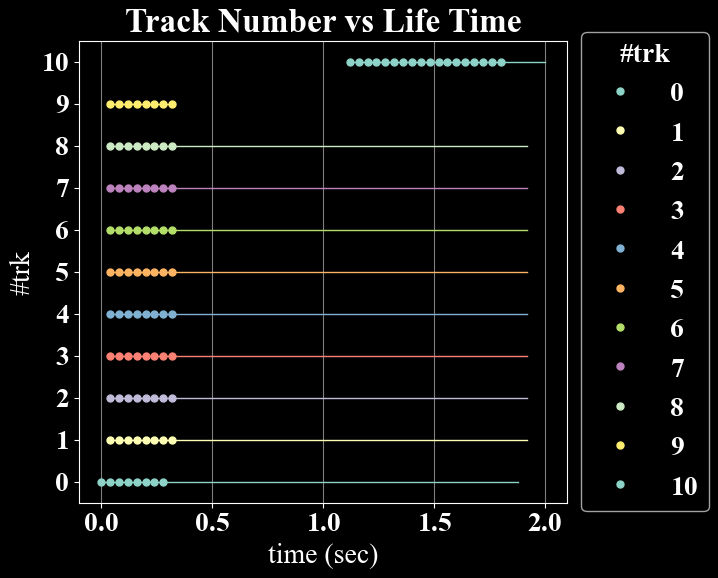

In [35]:
import matplotlib.ticker as ticker

plt.rcParams["font.family"] = 'Times New Roman' # "Britannic Bold" # "Modern Love"#  "Corbel Bold"# 
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'bold'

# plt.style.use()
# plt.style.use('ggplot') # 'dark_background' # 'default' # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'
plt.style.use('dark_background')  # 'default' # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'
# plt.style.use('default')  # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'
# plt.style.use('seaborn') # 'fivethirtyeight' # 'classic' # 'bmh'
# plt.style.use('fivethirtyeight')  # 'classic' # 'bmh'
# plt.style.use('classic')  # 'bmh'
# plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (9.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
plt.ion()



for k, v in ltrk.trackers.items():
    vstate = np.vectorize(lambda x: x.value)(v.get_data('state')[:, 1])
    iscorrect = np.where(vstate == trkstate.CORRECTED.value)[0]

    # fig0 = plt.figure(0)
    # ax0  = plt.subplot(111)
    # ax0.plot(v.get_data('t'), vstate)#, marker = '--', color = line[0].get_color(), linewidth = 0, label = str(k)) 

    fig1 = plt.figure(1)
    ax1  = plt.subplot(111)
    line = ax1.plot(v.get_data('t'), k * np.ones_like(v.get_data('t')), linewidth = 1)
    ax1.plot(v.get_data('t')[iscorrect], k * np.ones_like(iscorrect), marker = '.', color = line[0].get_color(), markersize = 10, linewidth = 0, label = str(k)) 
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(base = 1))




fig1 = plt.figure(1)
plt.legend(title = 'trk')
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.7, box.height])
ax1.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax1.set(xlabel = 'time (sec)',ylabel = '#trk')
ax1.set_title('Track Number vs Life Time', fontweight = 'bold')
ax1.grid(alpha = 0.5, axis = 'x')




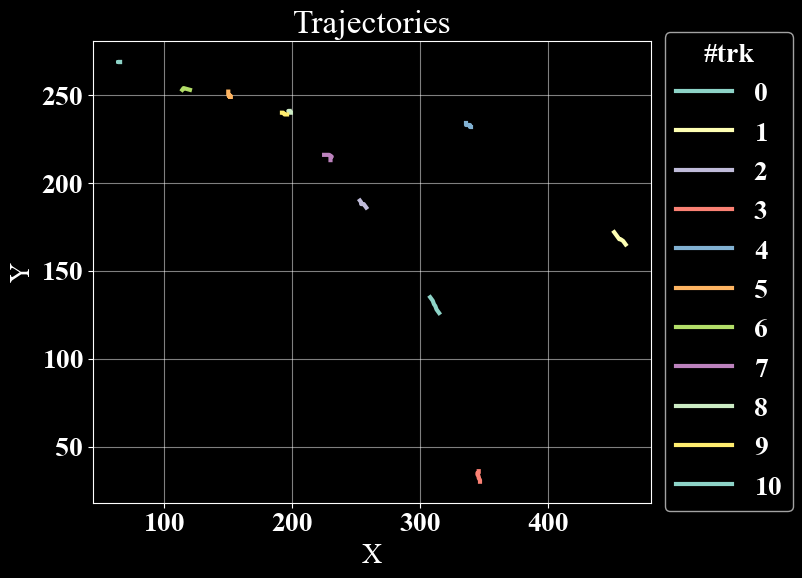

In [36]:
fig = plt.figure
ax = plt.subplot(111)

for k, v in ltrk.trackers.items():
    ax.plot(v.get_data('x'), fheight - v.get_data('y'), linewidth = 3, label = str(k))

plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'X',ylabel = 'Y')
ax.set_title('Trajectories')
ax.grid(alpha = 0.5)